#trainable한 CustomDataset class 만들기
-trainable: 바로 net에 물려서 사용할 수 있는 데이터셋
#전체적 과정
1. train_DS에 고양이, 강아지 이미지를 PIL 형태로 각각 50개씩 저장한 후 클래스도 지정해준다. img_Class도 만들어준다.
2. 모든 사진을 256x256 짜리로 padding을 통해 만들어준다.(나중에 안 건데, 굳이 padding하지 않고 img_paths에 있는 img를 PIL로 변환할 때 img=img.resize((256,256))하면 바로 이미지의 크기를 변환할 수 있다)
3. train_DS를 numpy 배열인 img_array로 만들어준다.
4. CustomDataset(img_array, img_label)로 (img, label)을 짝지을 수 있는 dataset을 만들어준다.
5. train_img로 DataLoader를 통해 데이터 로드 형태로 바꿔준다. batch_size는 10이다.
6. 데이터를 시각화해준다.
7. 간단한 net을 만들어준다.
8. criterion, optimizer을 설정해준다.
9. Train(model, train_img, criterion, optimizer) 함수를 정의해 train_img를 학습시킨다. loss와 acc를 학습을 척도로 사용한다. 사실 이건 그냥 데이터가 trainable한 지 보려고 만든 거다...음. trainable하네.

**image를 모두 불러오는 방법**:
1. PIL보다 cv2를 사용하자. PIL을 사용하면 이후 numpy로 바꿔줘야 하지만 cv2를 사용하면 image가 numpy로 변환된다.
2. apply, lambda, map, list comprehension 등의 메소드를 사용할 줄 아는 게 중요하다. ->속도가 빨라짐!
**과제**
1. map, lambda, apply 찾아보기/대용량 데이터 (빠르게) 처리하는 방법 찾아오기

In [ ]:
'''
import cv2
import time

path='/content/drive/24-1/강화시스터즈/.../train'
random_paths=random.sample(paths, 1000)

start=time.time()

with Pool(preocess=1000) as pool:
    img_list=pool.map(cv2.imread, random_paths)

print(time.time()-start)

이미지를 랜덤으로 추출했기 때문에 이미지마다 인덱싱이 불가능.->어떻게 ?

정규표현식을 사용한다. dir를 주면 그 dir에서 cat, dog만 뽑을 수 있다...

make_label은 함수...이므로 apply를 사용하면 좋다. 암튼 좋다.
make_label(df['path][2])->'cat'

'''


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from PIL import Image, ImageOps#PIL(Pillow Image Library)
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
dir='/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/train'

#img_path에 해당 dir에 있는 모든 이미지 데이터를 리스트에 저장한다.
#oslistdir(dir)는 해당 dir에 있는 파일의 이름을 반환하는 함수이다.
img_paths=[os.path.join(dir, filename) for filename in os.listdir(dir)]

#PIL로 변환한 이미지 데이터를 저장할 리스트
img_list=[]
#12000개 다 로드하기에는 시간이 너무 걸리므로 고양이 50개 강아지 50개
img_paths=img_paths[:50]+img_paths[12000:]
img_label=[]

#각 이미지 데이터를 순회하며 데이터를 읽어오고 저장한다.
for idx, img_path in enumerate(img_paths):
    #PIL로 이미지를 읽어와 png를 pytorch에서 다룰 수 있는 이미지로 만든다.
    img=Image.open(img_path)
    img_list.append(img)
    #고양이는 0, 강아지는 1이라는 라벨 부여
    if idx<=49:
        img_label.append(0)
    else:
        img_label.append(1)

train_DS=img_list

In [ ]:
img_class={0:'cat', 1:'dog'}

In [ ]:
#train_DS에 잘 저장되었는지 확인
print(train_DS[0])
print(len(train_DS))
print(type(train_DS[0]))#PIL image
print(list(set(img_label)))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=370x495 at 0x78E080BE38E0>
13300
<class 'PIL.JpegImagePlugin.JpegImageFile'>
[0, 1]


In [ ]:
#이미지의 크기를 padding을 통해 같게 만들기

#원하는 이미지 크기
target_size=(256,256)
img_resized=[]

for img in train_DS:
    width, height=img.size #(가로, 세로)의 길이 반환
    if width<target_size[0] or height<target_size[1]:
        padding_width=max(target_size[0]-width, 0)
        padding_height=max(target_size[1]-height, 0)
        #(left, up, right, down)
        '''
        좌측에 먼저 패딩이 적용되고 상단에 패딩이 적용될 때,
        좌측에 이미 추가된 패딩 역시 고려해서 상단 패딩이 적용된다.
        '''
        padding_size=(padding_width//2, padding_height//2, (padding_width+1)//2, (padding_height+1)//2)
        #img에 padding_size만큼 검정색(RGB)로 패딩
        img=ImageOps.expand(img, padding_size, fill=(0,0,0))
    if width>target_size[0] or height>target_size[1]:
        img=img.resize(target_size)

    img_resized.append(img)

print(img_resized[0])

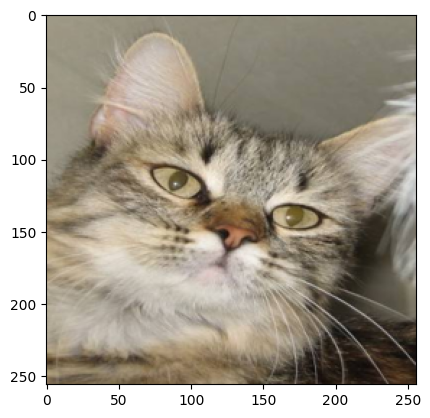

In [ ]:
plt.imshow(img_resized[0])

In [ ]:
#PIL 이미지를 numpy 배열로 변환
img_array=np.array(img_resized)
img_array=np.transpose(img_array, (0,3,1,2))#permute는 pytorch의 tensor에 사용된다.
print(img_array.shape)#(# of img, # of channel, size of img)
print(img_array[0])

(100, 3, 256, 256)
[[[158 158 158 ... 138 139 139]
  [158 158 158 ... 138 139 140]
  [158 158 158 ... 138 139 140]
  ...
  [141 137 130 ...  60  58  52]
  [138 134 127 ...  60  55  51]
  [139 135 130 ...  67  64  65]]

 [[153 153 153 ... 135 135 133]
  [153 153 153 ... 135 135 134]
  [153 153 153 ... 135 135 134]
  ...
  [121 117 110 ...  41  40  35]
  [118 114 108 ...  41  36  33]
  [119 114 110 ...  48  45  47]]

 [[134 134 134 ... 118 118 117]
  [134 134 134 ... 118 118 118]
  [134 134 134 ... 118 118 118]
  ...
  [ 95  92  85 ...  26  25  21]
  [ 94  90  84 ...  26  22  19]
  [ 96  92  87 ...  34  31  32]]]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_array, labels):
        self.img_array=img_array
        self.labels=labels

    def __len__(self):
        return len(self.img_array)

    def __getitem__(self, idx):
        img=self.img_array[idx]
        img=transforms.Compose([transforms.ToTensor()])(img)#img를 tensor로 바꾼 후
        img=img.permute(2,0,1)#차원 처리
        label=self.labels[idx]

        return img, label

In [ ]:
dataset=CustomDataset(img_array, img_label)
print(len(dataset))
img, label=dataset[0]
print("이미지 크기:", img.size())
print("라벨:", label)

100
이미지 크기: torch.Size([3, 256, 256])
라벨: 0


In [ ]:
train_img=DataLoader(dataset, batch_size=10, shuffle=True)

#잘 로드되었는지 확인
print(len(dataset)==len(train_img.dataset))

True


In [ ]:
iteration=iter(train_img)

In [ ]:
x_batch, y_batch=next(iteration)
print(x_batch.shape)#(batch_size, size of img, # of channel)
print(y_batch[0])

torch.Size([10, 3, 256, 256])
tensor(0)


Text(0.5, 1.0, 'cat')

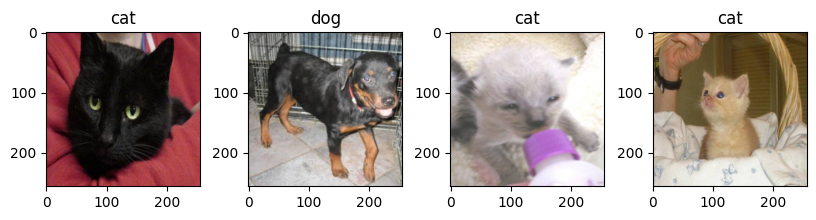

In [ ]:
#데이터 시각화

fig, (ax1, ax2, ax3, ax4)=plt.subplots(nrows=1, ncols=4, figsize=(10,2))

ax1.imshow(x_batch[0].permute(1,2,0), cmap='gray')
ax1.set_title(img_class[int(y_batch[0])])

ax2.imshow(x_batch[1].permute(1,2,0), cmap='gray')
ax2.set_title(img_class[int(y_batch[1])])

ax3.imshow(x_batch[2].permute(1,2,0), cmap='gray')
ax3.set_title(img_class[int(y_batch[2])])

ax4.imshow(x_batch[3].permute(1,2,0), cmap='gray')
ax4.set_title(img_class[int(y_batch[3])])

In [ ]:
#trainable한지 테스트하는 net

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.fc1=nn.Linear(16*62*62,120)
        self.fc2=nn.Linear(120, 84)
        self.fc3=nn.Linear(84,10)
        self.fc4=nn.Linear(10,2)

    def forward(self, x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=x.view(-1, self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.relu(self.fc4(x))

        return x

    def num_flat_features(self, x):
        size=x.size()[1:]
        num_features=1
        for s in size:
            num_features*=s
        return num_features

net=Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=61504, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)


In [ ]:
input=torch.randn(1,3,256,256)
output=net(input)
output

tensor([[0.1286, 0.0000]], grad_fn=<ReluBackward0>)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
#모델 학습
EPOCHS=3

train_arr=np.zeros((EPOCHS,2))

def Train(model, train_img, criterion, optimizer):

    length=len(train_img.dataset)
    model.train()#model train mode

    for epoch in range(EPOCHS):
        training_loss=0
        training_correct=0
        for idx, (x_batch, y_batch) in enumerate(train_img):
            #x_batch가 net을 통과했을 때 샘플 별 0/1일 확률
            y_hat=model(x_batch)
            #y_hat과 y_batch사이의 loss
            loss=criterion(y_hat, y_batch)
            training_loss+=loss.item()
            #optimizer 초기화->역전파->파라미터 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #pred는 y_hat의 최대값(그러니까 0이냐 1이냐)
            pred=y_hat.argmax(dim=1)
            #correct_sum에 pred가 y_batch와 일치하면 item으로 뽑아서 저장
            training_correct+=torch.sum(pred==y_batch).item()
        train_loss=training_loss/length
        train_acc=training_correct/length

        train_arr[epoch,:]=(train_loss, train_acc)
        print(f'epoch:{epoch+1} train loss:{round(train_loss,3)} train acc:{round(train_acc,3)}')

Train(net, train_img, criterion, optimizer)

epoch:1 train loss:0.072 train acc:0.46
epoch:2 train loss:0.068 train acc:0.54
epoch:3 train loss:0.072 train acc:0.47
